# Machine Learning with Python - Clustering



We are running a Cafe in Helsinki and want to segment the customers to find the best marketing strategy for the next summer. Such a customer segmentation can be done efficiently using __clustering methods__. 

In this exercise you learn how to group a set of data points (e.g. representing customers of a cafe) into coherent groups (**clusters** or segments) using **clustering methods**. You will learn about the hard clustering method __k-means__ and a soft clustering method based on a probabilistic **Gaussian mixture model** (GMM) for the data points. 

Both, $k$-means and soft clustering via GMM assume data points are represented by feature vectors $\mathbf{x}^{(i)}=\big(x^{(i)}_{1},\ldots,x^{(i)}_{n}\big)^{T}$ in the [Euclidean space]() $\mathbb{R}^{n}$. Moreover, these methods use the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) $\|\mathbf{x}^{(i)}-\mathbf{x}^{(j)}\|_2 = \sqrt{\sum_{t=1}^{n} \big( x^{(i)}_{t} - x^{(j)}_{t} \big)^{2} }$ between two data points as a measure for the (dis-)similarity between them.

In some applications, it is beneficial to use a different concept of similarity which is not directly tied to the Euclidean distance. Hence, we will also consider the clustering method [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) which uses a "non-Euclidean" notion of similarity between data points.

## Learning goals 

After this round, you should  

- be able to use k-means for hard clustering of a data set. 
- be able to use GMM for soft clustering of a data set. 
- be able to use DBSCAN for hard clustering of data points having a non-Euclidean structure. 
- be able to choose between different clustering methods. 

  
## Relevant Sections in [Course Book](https://arxiv.org/abs/1805.05052)

Chapter 8

## Additional Material 

* Prof. A. Ng explaining [hard-clustering via k-Means](https://www.youtube.com/watch?v=hDmNF9JG3lo)
* Prof. A. Ihler on [soft-clustering with Gaussian mixture models](https://www.youtube.com/watch?v=qMTuMa86NzU)
* scikit-learn page on [k-means](https://scikit-learn.org/stable/modules/clustering.html#k-means)
* scikit-learn page on [Gaussian mixture models](https://scikit-learn.org/stable/modules/mixture.html#mixture)
* scikit-learn page on [DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

##  Introduction

Clustering methods partition a dataset $\mathbb{X} = \{ \mathbf{x}^{(i)} \}_{i=1}^{m}$, consisting of $m$ data points $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$, into a small number of groups or "clusters" $\mathcal{C}_{1},\ldots,\mathcal{C}_{k}$. Each cluster $\mathcal{C}_{l}$ represents a subset of data points which are more similar to each other than to data points in another cluster. The precise meaning of two data points being "similar" depends on the application at hand. 

Clustering methods do not require labeled data and can be applied to data points characterized solely by its features $\mathbf{x}^{(i)}$. Therefore, clustering methods are referred to as **unsupervised** machine learning methods. However, clustering methods are often used in combination (e.g., as a preprocessing step) with supervised learning methods such as regression or classification. 

There are two main flavors of clustering methods: 

* Hard clustering methods assign each data point to exactly one cluster and 
* Soft clustering methods assign each data point to several different clusters with varying degrees of belonging.

Hard clustering can be interpreted as a special case of soft-clustering where the degrees of belonging are enforced to be either 0 (no belonging) or 1 (belongs).

In this exercise we will implement one popular method for hard clustering, the k-means algorithm, and one popular method for soft clustering, which is based on a probabilistic Gaussian mixture model (GMM). These two methods use a notion of similarity that is tied to the Euclidean geometry of $\mathbb{R}^{n}$. 
In some applications, it is more useful to use a different notion of similarity. The hard clustering method DBSCAN is an example of a clustering method which uses a non-Euclidean notion of similarity. 

## The Data

The file "data.csv" contains $m=400$ rows representing the data points $\mathbf{x}^{(i)}=
\big( x_{1}^{(i)},x_{2}^{(i)} \big)$, for $i=1,\ldots,m$. The first column of the $i$-th row in the file contains the age $x_{1}^{(i)}$ of the $i$-th customer. The second column contains the amount $x_{2}^{(i)}$ of money spent by the $i$-th customer.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Loading the Data. 
 

The following code snippet reads in $m=400$ data points from the csv file "data.csv". Data points are represented by feature vectors $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$, with $n=2$, for $i=1,\ldots,m=400$. The feature vectors are stacked into the data matrix 
$\mathbf{X}= \big( \mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)} \big)^{T} \in  \mathbb{R}^{m \times n} \tag{EqDataMtx}$ and then depicted using a scatter plot.

   </div>

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

# Read in data from the csv file and store it in the data matrix X.
df = pd.read_csv("/coursedata/R5_Clustering/data.csv")
X = np.array(df)

# Display first 5 rows
display(df.head(5))  

,Age,Spending
0,28.018868,5.263333
1,27.897623,5.276452
2,29.042011,4.794357
3,29.669165,5.207227
4,29.494291,6.351539


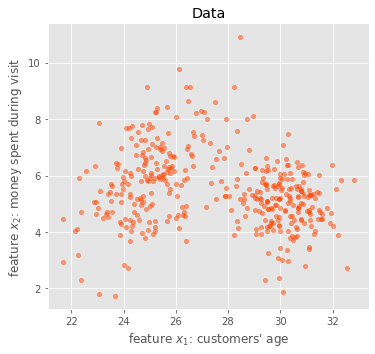

In [2]:
def plotting(data, centroids=None, clusters=None):
    # This function will later on be used for plotting the clusters and centroids. But now we use it to just make a scatter plot of the data
    # Input: the data as an array, cluster means (centroids), cluster assignemnts in {0,1,...,k-1}   
    # Output: a scatter plot of the data in the clusters with cluster means
    plt.figure(figsize=(5.75,5.25))
    data_colors = ['orangered', 'dodgerblue', 'springgreen']
    centroid_colors = ['red', 'darkblue', 'limegreen'] # Colors for the centroids
    plt.style.use('ggplot')
    plt.title("Data")
    plt.xlabel("feature $x_1$: customers' age")
    plt.ylabel("feature $x_2$: money spent during visit")

    alp = 0.5             # data points alpha
    dt_sz = 20            # marker size for data points 
    cent_sz = 130         # centroid sz 
    
    if centroids is None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp ,c=data_colors[0])
    if centroids is not None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp, c=data_colors[0])
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=cent_sz, c=centroid_colors[:len(centroids)])
    if centroids is not None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i] for i in clusters], s=dt_sz, alpha=alp)
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", c=centroid_colors[:len(centroids)], s=cent_sz)
    if centroids is None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i-1] for i in clusters], s=dt_sz, alpha=alp)
    
    plt.show()

# Plot the (unclustered) data
plotting(X)   

# Hard Clustering

Hard clustering partitions a data set $\mathbb{X}=\{\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)}\}$ into $k$ non-overlapping clusters $\mathcal{C}_1,\ldots,\mathcal{C}_k$. Each data point is assigned to precisely one cluster. We denote by $y^{(i)} \in \{1,\ldots,k\}$ the index of the cluster to which the $i$th data point $\mathbf{x}^{(i)}$ belongs to. 

The formal setup of hard clustering is quite similar to that of classification methods. We can interpret the cluster index $y^{(i)}$ as the label (quantity of interest) associated with the $i$:th data point. In contrast to classification problems, clustering methods do not require any labeled data points. 

Clustering methods do not require knowledge of the **true cluster assignment** for any data point. Instead, clustering methods learn a reasonable cluster assignment for a data point based on the intrinsic geometry of the entire dataset $\mathbb{X}$. Therefore, clustering methods are referred to as **unsupervised machine learning** methods since they do not need supervision in the form of labeled provided by some data points. 



## The k-Means Algorithm

A popular method for hard clustering is the k-means algorithm which takes as input a list of data points $\mathbb{X}= \{ \mathbf{x}^{(1)},...,\mathbf{x}^{(m)} \}$ and groups them into $k$ non-overlapping clusters $\mathcal{C}_{¡},\ldots,\mathcal{C}_{k}$. Each (non-empty) cluster $\mathcal{C}_{c} \subseteq \mathbb{X}$ is characterized by the cluster mean 

\begin{equation*}
\mathbf{m}^{(c)} = (1/|\mathcal{C}_{c}|) \sum_{\mathbf{x}^{(i)} \in \mathcal{C}_{c}} x^{(i)}, 
\end{equation*}

where $|\mathcal{C}_c|$ denotes the number of data points in the cluster $C_c$.

If we would know the cluster means $\mathbf{m}^{(c)}$ for each cluster, we could assign each data point $\mathbf{x}^{(i)}$ to the cluster with index $y^{(i)}$ whose mean is closest to $\mathbf{x}^{(i)}$: 
\begin{equation}
\| \mathbf{x}^{(i)} - \mathbf{m}^{y^{(i)}} \| = {\rm min}_{c \in \{1,\ldots,k\}}\| \mathbf{x}^{(i)} - \mathbf{m}^{(c)} \|. 
\end{equation} 
However, in order to determine the cluster means $\mathbf{m}^{(c)}$, we would have needed the cluster assignments $y^{(i)}$ already in the first place. This instance of an [egg-chicken dilemma](https://en.wikipedia.org/wiki/Chicken_or_the_egg) is resolved by the $k$-means algorithm as follows:

* __Input__: data points $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$, for $i=1,\ldots,m$ and number $k$ of clusters


* __Initialization__: choose initial cluster means $\mathbf{m}^{(1)},\ldots,\mathbf{m}^{(k)} \in \mathbb{R}^{n}$


* __Repeat Until Stopping Condition is Met:__  

    * __Update Cluster Assignments__: assign each data to the nearest cluster: 
    
    for each data point $i=1,\ldots,m$, set  
    
    \begin{equation*}
    y^{(i)} = \underset{c' \in \{1,\ldots,k\}}{\operatorname{argmin}} \|\mathbf{x}^{(i)} - \mathbf{m}^{(c')}\|^2 , 
    \tag{1}
    \end{equation*}
    
    * __Update Cluster Means__: determine cluster means for new cluster assignments 
    
    for each cluster $c=1,\ldots,k$, set 
    \begin{equation*}
    \mathbf{m}^{(c)} = \frac{1}{\mid\{i: y^{(i)}= c\}\mid}{\sum_{i: y^{(i)}= c}\mathbf{x}^{(i)}}     
    \label{mean}
    \tag{2}
    \end{equation*}
    where $\{i: y^{(i)}= c\}$ represents the set of datapoints belonging to cluster c and $\mid\{i: y^{(i)}= c\}\mid$ the size of cluster c.  
    


The working of $k$-means is best understood by walking through an example. To this end, we apply the $k$-means algorithm to the customer data discussed above.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Apply k-means. 

The code snippet below uses k-means to cluster the Cafe customers into $k=3$ clusters $\mathcal{C}_{1}$,$\mathcal{C}_{2}$ and $\mathcal{C}_{3}$. We hypothesize that these clusters represent three different customer segments. The resulting clusters are depicted in a scatter plot by using the same color for all data points in the same cluster. The cluster means (centers) $\mathbf{m}^{(1)}$, $\mathbf{m}^{(2)}$ and $\mathbf{m}^{(3)}$ are represented by crosses.   

 </div>

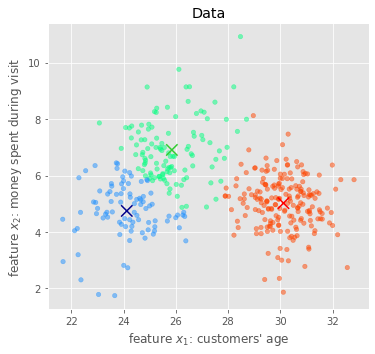

In [3]:
from sklearn.cluster import KMeans

m, n = X.shape    # Get the number of data points m and number of features n

k = 3    # Define number of clusters to use

cluster_means = np.zeros((k,n))    # Store the resulting clustering means in the rows of this np array
cluster_labels = np.zeros(m)    # Store here the resulting cluster indices (one for each data point)

k_means = KMeans(n_clusters = k, max_iter = 100).fit(X)  # Apply k-means with k=3 cluster and using maximum 100 iterations
cluster_means = k_means.cluster_centers_    # Get cluster means (centers)
cluster_indices = k_means.labels_           # Get the cluster labels for each data point

# Plot the clustered data
plotting(X, cluster_means, cluster_indices)

<a id='handsondata'></a>
<div class=" alert alert-warning">
    <b>Student Task.</b> Apply k-means. 
 

Apply the k-means algorithm on the customer data in the matrix `X` using the `scikit-learn` function `KMeans`. The function allows to specify the number of clusters and number of iterations with the input parameters `n_clusters` and `max_iter`. Use `max_iter=10` so that the function alternatingly updates the cluster assignment and cluster means $10$ times. Apply k-means with $k=2$ clusters. Do not set any other input parameter so that their default values are used. 

Store the resulting cluster means in the numpy array `cluster_means` of shape (2,2) and the resulting cluster assignments in the numpy array `cluster_indices` of shape (400, ). 

[Documentation of k-means in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

 </div>

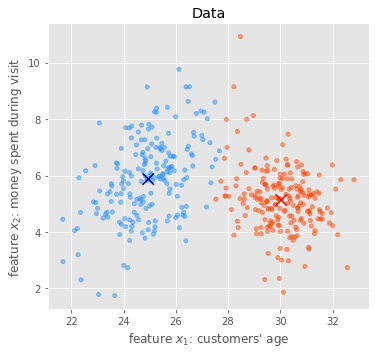

The final cluster mean values are:
 [[30.03164456  5.13271688]
 [24.94326652  5.87406858]]


In [4]:
from sklearn.cluster import KMeans

m, n = X.shape    # Get the number of data points m and number of features n

k = 2    # The number of clusters to use

cluster_means = np.zeros((k,n))    # Store the resulting clustering means in the rows of this np array
cluster_indices = np.zeros(m)    # Store here the resulting cluster indices (one for each data point)

np.random.seed(1)    # Set random seed for reproducability (DO NOT CHANGE THIS!)

### STUDENT TASK ###
# ...
# cluster_means = ...
# cluster_indices = ...

# YOUR CODE HERE
#raise NotImplementedError()
k_means = KMeans(n_clusters = k, max_iter = 10).fit(X)
cluster_means = k_means.cluster_centers_   
cluster_indices = k_means.labels_

# Plot the clustered data
plotting(X, cluster_means, cluster_indices)
print("The final cluster mean values are:\n", cluster_means)


In [5]:
# Perform some sanity checks on the outputs
assert X.shape == (400, 2), f'numpy array X has wrong shape'
assert cluster_means.shape == (2, 2), f'numpy array cluster_means has wrong shape'
assert cluster_indices.shape == (400,), f'numpy array cluster indices has wrong shape'
assert cluster_means[0, 0] > 30, f'the value at cluster_means[0,0] is too small'

print('Sanity check tests passed!')


Sanity check tests passed!


## Handling Local Minima

As discussed in Section 8.1 of the course book, the k-means algorithm can be interpreted as method for minimizing the **clustering error**: 
$$\mathcal{E}  ( \{\mathbf{m}^{(c)}\}_{c=1}^{k},\{y^{(i)}\}_{i=1}^{m} \mid \{\mathbf{x}^{(i)}\}_{i=1}^{m} )
=(1/m) \sum_{i=1}^{m} {\left\|\mathbf{x}^{(i)}-\mathbf{m}^{(y^{(i)})}\right\|^2}. 
\label{EqErr}
\tag{3}
$$
Indeed, the k-means updates amount to alternatingly optimization of $\mathcal{E}  ( \{\mathbf{m}^{(c)}\}_{c=1}^{k},\{y^{(i)}\}_{i=1}^{m} \mid \{\mathbf{x}^{(i)}\}_{i=1}^{m} )$ over varying choices for cluster means $\mathbf{m}^{(c)}$ with cluster assignments $y^{(i)}$ held fixed and vice-versa. 

The optimization interpretation of k-Means allows us to define a criterion for when to stop iterating the cluster assignment and means updates. The input parameter `tol` of the Python function `KMeans` allows us to specify a relative value of objective decrease that is used to define convergence (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)). However, in this exercise we will use the simpler approach of using a fixed number of iterations used by k-Means. 

Since the clustering error is a [non-convex function](https://stats.stackexchange.com/questions/324561/difference-between-convex-and-concave-functions) of the cluster means and assignments, the k-means method might get trapped in a [**local minimum**](https://en.wikipedia.org/wiki/Maxima_and_minima#/media/File:Extrema_example_original.svg). This would mean that the k-means algorithm would terminate before finding the best possible clustering, measured the clustering error. It is therefore useful to repeat k-means **several times with different initializations** for the cluster means and choose the cluster assignment resulting in the smallest empirical risk among all repetitions. 

<div class="alert alert-warning">

<b> Student Task.</b> Repeat $k$-means To Escape Local Minima.

Repeat $k$-means $50$ times using $k=3$ clusters and $L=10$ iterations in each repetition. In the $r$th repetition use the $r$-th row of the numpy arrays `init_mean_cluster1`, `init_mean_cluster2`, `init_mean_cluster3` as initial cluster means for the Python function `KMeans`. 
The cluster assignments obtained from those two repetitions achieving the smallest and largest clustering error should be stored in the numpy array `best_assignment` and `worst_assignment` each of shape (400,1). The index (starting at 0) of the repetition yielding the smallest clustering error should be stored in the variable `min_ind`. The index (starting at 0) of the repetition yielding the largest clustering error should be stored in the variable `max_ind`. 

Hint: The sum of the squared distances of the data points to their respective centers is stored in the attribute `KMeans.inertia_` after fitting the k-means model. This value can be used to calculate the clustering error with the formula in (3). 

</div>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Explicit initial center 

Cluster assignment with smallest clustering error:


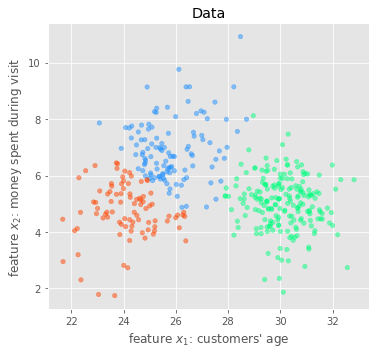

Cluster assignment with largest clustering error:


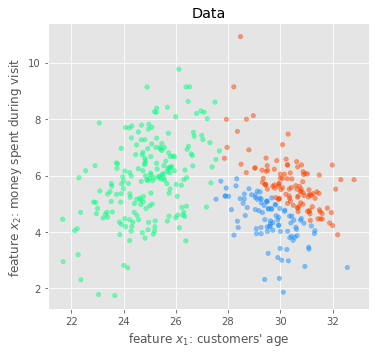

In [6]:

m = X.shape[0]  # Number of data points

min_ind = 0  # Store here the index of the repetition yielding smallest clustering error 
max_ind = 0  # .... largest clustering error

cluster_assignment = np.zeros((50, m), dtype=np.int32)  # Array for storing clustering assignments
clustering_err = np.zeros(50,)    # Array for storing the clustering errors for each assignment

np.random.seed(42)   # Set random seed for reproducability (DO NOT CHANGE THIS!)

init_means_cluster1 = np.random.randn(50,2)  # Use the rows of this numpy array to init k-means 
init_means_cluster2 = np.random.randn(50,2)  # Use the rows of this numpy array to init k-means 
init_means_cluster3 = np.random.randn(50,2)  # Use the rows of this numpy array to init k-means 

best_assignment = np.zeros((400,1))     # Store here the cluster assignment achieving the smallest clustering error
worst_assignment = np.zeros((400,1))    # Store here the cluster assignment achieving the largest clustering error

### STUDENT TASK ###
# ...
# best_assignment = ...
# worst_assignment = ...
# YOUR CODE HERE
# raise NotImplementedError()

k=3


for item in range(init_means_cluster1.shape[0]):
    
    init_init=np.zeros((3,2))
    init_init[0]=init_means_cluster1[item]
    init_init[1]=init_means_cluster2[item]
    init_init[2]=init_means_cluster3[item]

    k_means = KMeans(n_clusters = k, max_iter = 10, init=init_init).fit(X)
    
    clustering_err[item]=k_means.inertia_/m
    cluster_assignment[item]=k_means.labels_
    
    
min_ind=clustering_err.argmin()
max_ind=clustering_err.argmax()


best_assignment = cluster_assignment[min_ind,:]
worst_assignment = cluster_assignment[max_ind,:]


# Plot the best and worst cluster assignments (w.r.t. clustering error)
print("Cluster assignment with smallest clustering error:")
plotting(X, clusters = cluster_assignment[min_ind,:])
print("Cluster assignment with largest clustering error:")
plotting(X, clusters = cluster_assignment[max_ind,:])



In [7]:
# Perform some sanity checks on the solution
assert all(best_assignment) == 0, 'You have to assign value for best_assignment ' 
assert all(worst_assignment) == 0, 'You have to assign value for worst_assignment ' 
assert best_assignment.shape[0] == 400, 'incorrect cluster labels for minimal clustering error'
assert worst_assignment.shape[0] == 400, 'incorrect cluster labels for maximal clustering error'
print('Sanity check tests passed!')


Sanity check tests passed!


## How Many Clusters ? 

Sometimes it is not clear what a good choice for the number $k$ of clusters should be. One (data-driven) way to choose $k$ is to run k-means for increasing values of $k$ until the clustering error is below a prescribed level (say $10$ percent).  

<div class="alert alert-warning">

<b> Student Task.</b> Try out different number $k$ of clusters. 


Apply k-means to the Cafe customer data for the choices $k=1,\ldots,8$. For each choice of $k$, run KMeans once with $L=100$ iterations. Store the resulting clustering error in the numpy array `err_clustering` of shape (8,1).  

</div>

Clustering errors: 
[[9.5232033 ]
 [2.92348141]
 [2.02178865]
 [1.65213431]
 [1.3702528 ]
 [1.19038511]
 [1.01622526]
 [0.91495062]]


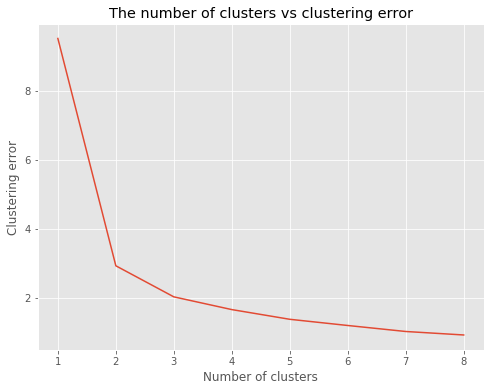

In [8]:
m = X.shape[0]    # Number of data points
err_clustering = np.zeros((8,1))    # Array for storing clustering errors

### STUDENT TASK ###
# YOUR CODE HERE
#raise NotImplementedError()

for i in range(0,8):
    k=i+1
    k_means = KMeans(n_clusters = k, max_iter = 100).fit(X)
    err_clustering[i,:]=k_means.inertia_/m
    

print(f'Clustering errors: \n{err_clustering}')

# Plot the clustering error as a function of the number k of clusters
plt.figure(figsize=(8,6))
plt.plot(range(1,9), err_clustering)
plt.xlabel('Number of clusters')
plt.ylabel('Clustering error')
plt.title("The number of clusters vs clustering error")
plt.show()  




In [9]:
# Perform some sanity checks on the outputs
assert all(err_clustering > 0), 'Store clustering errors for varing number of clusters' 
assert err_clustering.shape == (8, 1), 'Incorrect shape for errors of models. Use the pre-defined variable err_clustering'
np.testing.assert_allclose(err_clustering[0], 9.5, atol = 0.5 ), 'clustering error when using one cluster is incorrect!'
np.testing.assert_allclose(err_clustering[7], 1, atol = 0.5), 'clustering error when using eight clusters is incorrect!'

print('Sanity check tests passed!')


Sanity check tests passed!


In the figure above, we can see that the clustering error decreases monotoneously with an increasing number of clusters. This is as expected since the addition of an additional cluster cannot result in a larger average distance from the points to their corresponding cluster centroids.

# Soft Clustering 

The information provided by the cluster assignments $y^{(i)}$, for $i=1,\ldots,m$, delivered by $k$-means is rather coarse-grained, as each data point belongs to only one cluster. Even if two data points belong to the same cluster, their location within the cluster might be very different. Consider the data set whose scatter plot is shown below. The data points represented by blue dots that lie outside the biggest circle are somewhat in-between different clusters. However, the cluster assignments delivered by k-means do not reflect the different locations of data points relative to the center of the cluster. In some applications it is useful to measure the degree of a data point belonging to a cluster. 

<center>
    <img src="../../../coursedata/R5_Clustering/graph_example.png" alt="Example of not good hard-clustering"/>
</center>

## Probabilistic Models

When applying a **probabilistic model**, we interpret data points as realizations of random variables and try to fit a probability distribution to them. For example, when applying a Gaussian model to a dataset we assume that the data is normally distributed, and fit a normal distribution to the data by finding the optimal values for the mean and variance of the distribution, e.g. the mean and variance that maximize the likelihood of observing the data (assuming the data is generated from a Gaussian distribution). 

In this section we will demonstrate how to use the [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) and [`multivariate_normal`](http://lagrange.univ-lyon1.fr/docs/scipy/0.17.1/generated/scipy.stats.multivariate_normal.html) to fit gaussian models to datasets.
The Gaussian distribution is important because many processes in nature and social sciences can be accurately modeled using Gaussian random variables.



<a id='FitProbabilisticDemo'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Fitting a Gaussian Mixture Model to Data.  
   

The code snippet below fits a mixture of two Gaussian distributions to data points which are generated using a random number generator. In particular, the data points are sampled from a mixture of two Gaussian distributions with different mean and covariance. Gaussian mixture models (GMM) are implemented in the Python class [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture). Fitting a GMM to data points is done using the function `GaussianMixture.fit()`. Thus, instead of fitting a GMM using pen and paper (solving a difficult [maximum likelihood problem](https://stephens999.github.io/fiveMinuteStats/intro_to_em.html)) we can use one line of Python code :-) 

 </div>

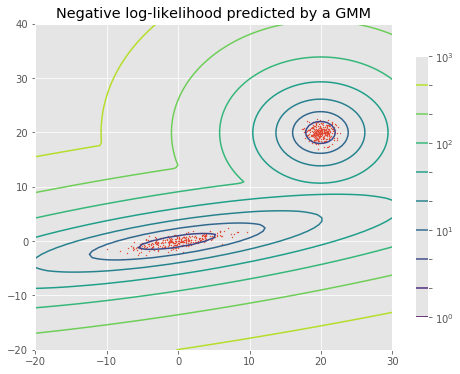

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture

m = 300    # Define number of data points to generate from each distribution
np.random.seed(0)    # Set random seed for reproducability (DO NOT CHANGE!)

# Generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(m, 2) + np.array((20, 20))

# Generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])  
stretched_gaussian = np.dot(np.random.randn(m, 2), C)

# Concatenate the two datasets into the final simulateda dataset
X_sim = np.vstack([shifted_gaussian, stretched_gaussian])

# Fit a Gaussian Mixture Model with two components
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=1)
gmm.fit(X_sim)

# Display predicted scores by the model as a contour plot
x = np.linspace(-20, 30, 100)
y = np.linspace(-20, 40, 100)
X_mg, Y_mg = np.meshgrid(x, y)
XX = np.array([X_mg.ravel(), Y_mg.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X_mg.shape)

plt.figure(figsize=(8,6))
CS = plt.contour(X_mg, Y_mg, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_sim[:, 0], X_sim[:, 1], .8)    # Scatterplot the datapoints onto the same figure

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

##  Gaussian Mixture Models 

Let us now consider soft-clustering methods which provide a more fine-grained information about the cluster structure of a data set. For the customer segmentation for a Cafe business, we might need some measure for the extent (or degree) by which a customer belongs to various groups. Soft-clustering methods associate each data point $\mathbf{x}^{(i)}$ with a "cluster-membership" vector $\mathbf{y}^{(i)}= (y^{(i)}_1,...,y^{(i)}_k) \in [0,1]^k$. The entry $y^{(i)}_c$ is the degree of confidence by which we assign $\mathbf{x}^{(i)}$ to cluster $\mathcal{C}_c$. 

A principled approach to soft-clustering is based on interpreting data points $\mathbf{x}^{(i)}$ as realizations of a random vector $\mathbf{x}$ with probability distribution $p(\mathbf{x})$. Soft-clustering assumes that each data points is obtained by randomly drawing from one of $k$ different clusters. Each cluster $\mathcal{C}_{c}$ corresponds to a [Gaussian random vector](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) with some mean vector $\mathbf{\mu}^{(c)}$ and covariance matrix $\mathbf{C}^{(c)}$. The probability density function (pdf) of a Gaussian random vector $\mathbf{x}$ with mean $\mu$ and covariance matrix $\mathbf{C}$ is given as 

\begin{equation}
\mathcal{N}(\mathbf{x} ; \mathbf{\mu}, \mathbf{C}) = \frac{1}{\sqrt{{\rm det} \big(2 \pi \mathbf{C}\big)}} {\rm exp } \bigg( -\frac{1}{2} \big(\mathbf{x} - \mathbf{\mu} \big)^{T} \mathbf{C}^{-1}  \big(\mathbf{x} - \mathbf{\mu}\big)\bigg).
\end{equation}

Note that this expression is only valid for Gaussian random vectors having a non-singular (invertible) covariance matrix $\mathbf{C}$. The resulting pdf of a data point is a **Gaussian mixture model (GMM)**  
\begin{equation}
p(\mathbf{x}) = \sum_{c=1}^{k} p_{c} \mathcal{N}(\mathbf{x};\mathbf{\mu}^{(c)},\mathbf{C}^{(c)}). 
\end{equation}
The coefficients $p_{c} \geq 0$ are required to satisfy $\sum_{c=1}^{k}p_c=1$ and represent the (prior) probability that a data point is drawn from cluster $\mathcal{C}_{c}$. 

Note that the GMM $p(\mathbf{x})$ is parametrized by 

* the cluster probabilities $p_{1},p_{2}, ..., p_k$, 
* the cluster means $\mathbf{\mu}^{(1)},\mathbf{\mu}^{(2)},..., \mathbf{\mu}^{(k)}$ 
* and the covariance matrices $\mathbf{C}^{(1)},\mathbf{C}^{(2)},..., \mathbf{C}^{(k)}$.

Using the GMM $p(\mathbf{x})$, we can make the notion of a degree of belonging precise. In particular, we define the degree $y_{c}^{(i)}$ of a data point $\mathbf{x}^{(i)}$ belonging to cluster $\mathcal{C}_{c}$ as the (posterior) probability that $\mathbf{x}^{(i)}$ is generated (drawn) from the Gaussian distribution associated with $\mathcal{C}_{c}$:  

$$\mathbf{y}^{(i)}_c = \frac{p_{c} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{\mu}^{(c)}, \mathbf{C}^{(c)})}{\sum_{c'=1}^k p_{c'} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{\mu}^{(c')}, \mathbf{C}^{(c')})} $$

After determining the degrees of belonging $\mathbf{y}^{(i)}_c$, we can update our guess for (estimate of) the cluster probabilities $p_{c}$, cluster means $\mathbf{\mu}^{(c)}$ and covariance matrix $\mathbf{C}^{(c)}$.

In summary this algorithm consists of 4 steps:

* __Step 1 - Initialize the cluster parameters. These are the means and covariances for every cluster.__
* __Step 2 - Update the degree of data point $\mathbf{x}^{(i)}$ belonging to cluster c.__
* __Step 3 - Update cluster probabilities $p_{c}$, means $\mathbf{\mu}^{(c)}$ and covariances $\mathbf{C}^{(c)}$.__
* __Step 4 - If stopping criterion is not satisfied, go to step 2__

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Plotting GMM. 

The code snippet below implements a helper-function `plot_GMM()` which can be used to illustrate GMM along with the scatterplot of data points. You do not need to understand the details, but feel free to explore it.

  </div>

In [11]:
def plot_GMM(data, means, covariances, k, clusters=None):
    
    ## Select three colors for the plot
    # if you want to plot curves k>3, extend these lists of colors
    data_colors = ['orangered', 'dodgerblue', 'springgreen'] # colors for data points
    centroid_colors = ['red', 'darkblue', 'limegreen'] # colors for the centroids
    
    k = means.shape[0]
    plt.figure(figsize=(8,6))    # Set figure size
    if clusters is None:
        plt.scatter(data[:,0], data[:,1], s=13, alpha=0.5)
    else:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i] for i in clusters], s=13, alpha=0.5)

    # Visualization of results
    x_plot = np.linspace(19, 35, 100)
    y_plot = np.linspace(0, 12, 100)
    x_mesh, y_mesh = np.meshgrid(x_plot, y_plot)
    pos = np.empty(x_mesh.shape + (2,))
    pos[:,:,0] = x_mesh 
    pos[:,:,1] = y_mesh

    # For each cluster, plot the pdf, defined by the mean and covariance, and the mean
    for i in range(k):
        z = multivariate_normal.pdf(pos, mean = means[i,:], cov = covariances[i])
        plt.contour(x_mesh, y_mesh, z, 4, colors=centroid_colors[i], alpha=0.5)
        plt.scatter(means[i,0], means[i,1], marker='x', c=centroid_colors[i])

    plt.title("Soft clustering with GMM")
    plt.xlabel("feature x_1: customers' age")
    plt.ylabel("feature x_2: money spent during visit")
    plt.show()

<a id='handsondata'></a>
<div class=" alert alert-warning">
    <b>Student task.</b> Soft clustering using GMM. 

Your task is to perform soft clustering on the customer data using a GMM model. The means of the components of the fitted GMM should be stored in the variable `means`, the covariance matrices in `covariaces`, and the cluster labels (or indices) in `cluster_labels`.

The final result of the clustering will be plotted below.
</div>

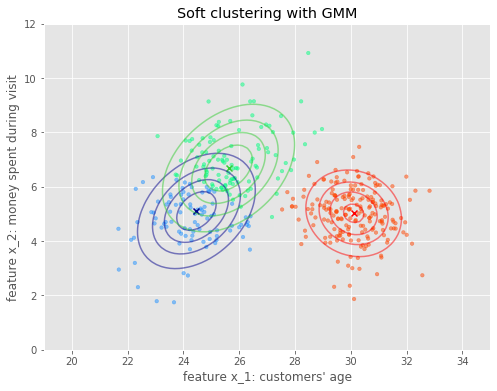

The means are:
 [[30.09938306  5.02145697]
 [24.46484646  5.10831508]
 [25.6154086   6.6874243 ]] 

The covariance matrices are:
 [[[ 1.00676569 -0.1164302 ]
  [-0.1164302   0.87158468]]

 [[ 1.42319654  0.51707087]
  [ 0.51707087  1.43739154]]

 [[ 1.75539668  0.64515293]
  [ 0.64515293  1.72661107]]]


In [12]:
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal # Multivariate normal random variable

n, m = X.shape

# Define the number of clusters
k = 3

means = np.zeros((k, m))  # Array for storing the cluster means
covariances = np.zeros((k, m, m))  # Array for storing the covariance matrices
cluster_labels = np.zeros(n)  # Array for storing the cluster labels of each data point

np.random.seed(1)    # Set random seed for reproducability 

### STUDENT TASK ###
# ...
# ...
# y_pred = ...
# means = ...
# covariances = ...
# YOUR CODE HERE
#raise NotImplementedError()

gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=1)
gmm.fit(X)


means = gmm.means_
covariances = gmm.covariances_
cluster_labels = gmm.predict(X)

plot_GMM(X, means, covariances, k, cluster_labels)
print("The means are:\n", means, "\n")
print("The covariance matrices are:\n", covariances)


In [13]:
# Perform some sanity check on the outputs
assert means.shape == (3, 2), "The shape of 'means' is wrong!"
assert covariances.shape == (3, 2, 2), "The shape of 'covariances' is wrong!"
assert cluster_labels.shape == (X.shape[0],)

print('Sanity checks passed')

Sanity checks passed


# Density Based Clustering

Both k-means and GMM cluster data points according to their Euclidean distance. These methods judge the simiarity between two data points solely based on their Euclidean distance, which is in many cases a suitable measure. However, in some applications the data conforms to a different non-Euclidean structure. 

One important non-Euclidean structure is based on the notion of connectivity. Here, two data points are considered similar if they can be reached by intermediate data points that have a small Euclidean distance. Two data points can be similar even if their Euclidean distance is large.

<img src="../../../coursedata/R5_Clustering/DBSCAN.png" alt="Drawing" style="width: 500px;height: 200px"/>


**Density-based spatial clustering of applications with noise (DBSCAN)** is a hard clustering method that uses a connectivity based similarity measure. In contrast to k-means and GMM, DBSCAN does not require the number of clusters to be pre-defined; the number of clusters will depend on its parameters. Moreover, DBSCAN allows to detect outliers  which can be interpreted as degenerated clusters consisting of exactly one data point. For a detailed discussion of how DBSCAN works, we refer to https://en.wikipedia.org/wiki/DBSCAN.  

<img src="../../../coursedata/R5_Clustering/DBSCAN.gif" alt="Drawing" style="width: 500px;"/>

DBSCAN is implemented in the scikit-learn function `DBSCAN.fit_predict()` [Documentation can be found here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). DBSCAN requires specification of two design parameters  `eps` and `min_samples`. The meaning of these parameter are well explained [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). 
The DBSCAN implementation `fit_predict(self, X[, y, sample_weight])` returns cluster labels.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Generating two datasets with different structures. 

The code snippet below creates two datasets $\mathbb{X}^{(1)}$ and $\mathbb{X}^{(2)}$ with different structures, which will be used to present the usefulness of DBSCAN. The datasets are stored in the numpy arrays `dataset1` and `dataset2` respectively.

</div>

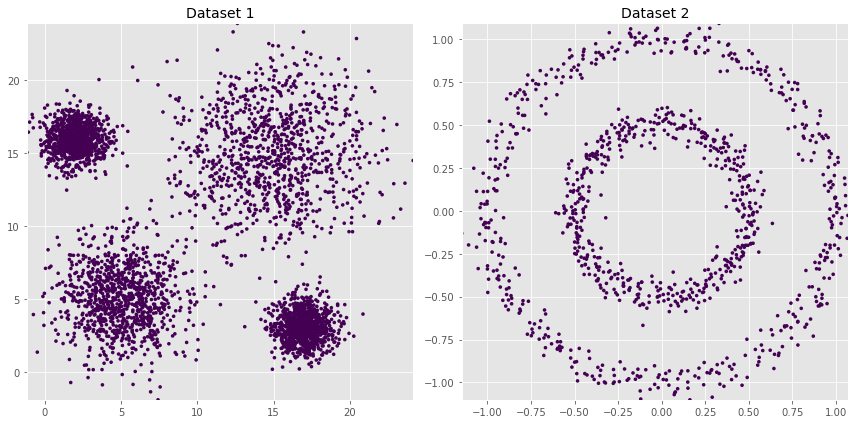

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

np.random.seed(844)    # Set random seed for reproducability

# Create dataset with separate Gaussian clusters
clust1 = np.random.normal(5, 2, (1000,2))
clust2 = np.random.normal(15, 3, (1000,2))
clust3 = np.random.multivariate_normal([17,3], [[1,0],[0,1]], 1000)
clust4 = np.random.multivariate_normal([2,16], [[1,0],[0,1]], 1000)
dataset1 = np.concatenate((clust1, clust2, clust3, clust4))

# Create dataset containing circular data
dataset2 = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0]

# Function for plotting clustering output on two datasets
def cluster_plots(data_1, data_2, clusters_1, clusters_2, title1='Dataset 1',  title2='Dataset 2'):
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title(title1,fontsize=14)
    ax[0].set_xlim(min(data_1[:,0]), max(data_1[:,0]))
    ax[0].set_ylim(min(data_1[:,1]), max(data_1[:,1]))
    ax[0].scatter(data_1[:,0], data_1[:,1], s=13, lw=0, c=clusters_1)
    ax[1].set_title(title2,fontsize=14)
    ax[1].set_xlim(min(data_2[:,0]), max(data_2[:,0]))
    ax[1].set_ylim(min(data_2[:,1]), max(data_2[:,1]))
    ax[1].scatter(data_2[:,0], data_2[:,1], s=13, lw=0, c=clusters_2)
    fig.tight_layout()
    plt.show()

# Plot the unclustered datasets (i.e. all points belonging to cluster 1)
cluster_plots(dataset1, dataset2, np.ones(dataset1.shape[0]), np.ones(dataset2.shape[0]))

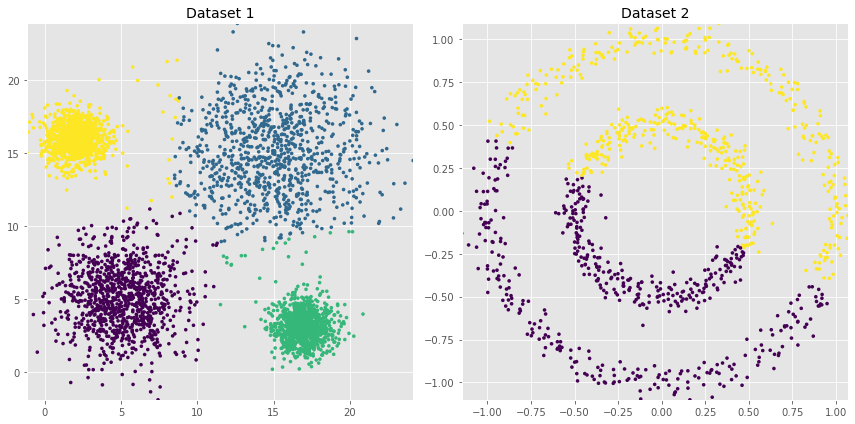

In [15]:
from sklearn.cluster import KMeans

# Perform k-means clustering on both datasets, and get the clusters for each datapoint
k_means_1 = KMeans(n_clusters=4)
k_means_2 = KMeans(n_clusters=2)
clusters_1 = k_means_1.fit_predict(dataset1)
clusters_2 = k_means_2.fit_predict(dataset2)

# Plot the clustered datasets
cluster_plots(dataset1, dataset2, clusters_1, clusters_2)

The shortcomings of k-means when applied to the circular data are apparent in the figure above. While k-means produces a reasonable clustering of the first dataset $\mathbb{X}^{(1)}$, it fails to find the intrinsic cluster structure of the second dataset $\mathbb{X}^{(2)}$.

<div class="alert alert-warning">

<b> Student Task.</b> Clustering with DBSCAN. 

Apply DBSCAN to the two datasets $\mathbb{X}^{(1)}$ and $\mathbb{X}^{(2)}$ stored in the numpy arrays `dataset1` and `dataset2`.
Use the parameter choices `min_samples=5`, `metric='euclidean'` and `eps` value $1$ for $\mathbb{X}^{(1)}$ and value $0.1$ for dataset $\mathbb{X}^{(2)}$. 
Use the `fit_predict(dataset)` method to obtain the cluster assignments for the data points in each of the two data sets and store them in the numpy arrays `dbscan_dataset1` and `dbscan_dataset2`, respectively. 

* `dbscan_dataset1` should be of dimensions $4000 \times 1$

* `dbscan_dataset2` should be of dimensions $1000 \times 1$

* for each dataset, count the number of data points whose cluster index is `-1` and store them in the variables `dataset1_noise_points` and `dataset2_noise_points`. 


</div>

Noise points in Dataset 1:
 47/4000 

Noise points in Dataset 2:
 2/1000 



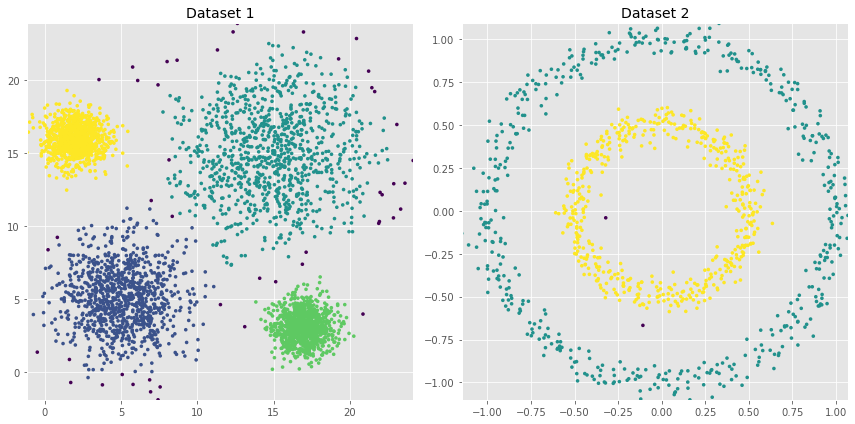

In [16]:
from sklearn.cluster import DBSCAN

# Define eps values for the two datasets
eps_1 = 1
eps_2 = 0.1

### STUDENT TASK ###
# clusters_1 = DBSCAN(eps = ...  
# clusters_2 = DBSCAN(eps = ...
# dataset1_noise_points = ...
# dataset2_noise_points = ...
# YOUR CODE HERE
# raise NotImplementedError()

clusters_1=np.zeros((4000,1))
clusters_2=np.zeros((1000,1))

clusters_1 = DBSCAN(eps = eps_1, min_samples=5, metric='euclidean').fit_predict(dataset1)
clusters_2 = DBSCAN(eps = eps_2, min_samples=5, metric='euclidean').fit_predict(dataset2)


dataset1_noise_points = np.count_nonzero(clusters_1 == -1)
dataset2_noise_points = np.count_nonzero(clusters_2 == -1)

print(f'Noise points in Dataset 1:\n {dataset1_noise_points}/{len(clusters_1)} \n')
print(f'Noise points in Dataset 2:\n {dataset2_noise_points}/{len(clusters_2)} \n')

# Plot the clustered datasets
cluster_plots(dataset1, dataset2, clusters_1, clusters_2)

In [17]:
# Perform some sanity checks on the outputs
assert clusters_1.shape == (4000,), 'Shape of dbscan_dataset1 is wrong.'
assert clusters_2.shape == (1000,), 'Shape of dbscan_dataset1 is wrong.'
assert dataset1_noise_points < 50, 'Number of noise points in dataset 1 should be less than 50.'
assert dataset2_noise_points < 5, 'Number of noise points in dataset 2 should be less than 5.'

print('Sanity check tests passed!')


Sanity check tests passed!


<a id='QuestionR5_1'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R5.1. </p>

 <p>Which of the following statements is true?</p>

<ol>
  <li> Clustering methods require labeled data points.</li>
  <li> Clustering methods aim at predicting a numeric quantity.</li>
  <li> Clustering methods do not require any labels.</li>
  <li> Clustering methods can only be used for less than 500 data points.</li>
</ol> 

</div>

In [18]:
answer_R5_Q1  = 3
# YOUR CODE HERE
# raise NotImplementedError()

In [19]:
# this cell is for tests
assert answer_R5_Q1 in [1,2,3,4], '"answer_R5_Q1" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!


<a id='QuestionR5_2'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R5.2. </p>

 <p>Which of the following statements is true?</p>

<ol>
  <li> DBSCAN is a soft clustering method.</li>
  <li> DBSCAN automatically determines the number of clusters.</li>
  <li> DBSCAN requires labeled data.</li>
  <li> DBSCAN can only be used for less than $1000$ data points.</li>
</ol> 

</div>

In [20]:
answer_R5_Q2  = 2
# YOUR CODE HERE
#raise NotImplementedError()

In [21]:
# this cell is for tests
assert answer_R5_Q2 in [1,2,3,4], '"answer_R5_Q2" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!


<a id='QuestionR5_2'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R5.3. </p>

 <p>What is the maximum length of feature vectors $\mathbf{x}^{(i)}$ that can be handled using k-means ?</p>

<ol>
  <li> Given sufficient computational resources, k-means can handle arbitrarily long feature vectors.</li>
  <li> $100$   </li>
  <li> $1000$  </li>
  <li> $10^{10}$ </li>
</ol> 

</div>

In [22]:
answer_R5_Q3  = 1
# YOUR CODE HERE
#raise NotImplementedError()

In [23]:
# this cell is for tests
assert answer_R5_Q3 in [1,2,3,4], '"answer_R5_Q3" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!
